<a href="https://colab.research.google.com/github/28nahidhasan/Machine-Learning/blob/main/Copy_of_Nahid().ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA PREPROCESSING

In [ ]:
!pip install kaggle scikit-learn tensorflow imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from google.colab import files

# Load and merge datasets

In [ ]:
uploaded = files.upload()
file_list = [f for f in uploaded.keys() if 'Dhaka_PM2.5' in f]
dfs = [pd.read_csv(f) for f in file_list]
merged_df = pd.concat(dfs, ignore_index=True)


Saving Dhaka_PM2.5_2016.csv to Dhaka_PM2.5_2016 (1).csv
Saving Dhaka_PM2.5_2017.csv to Dhaka_PM2.5_2017 (1).csv
Saving Dhaka_PM2.5_2018.csv to Dhaka_PM2.5_2018 (1).csv
Saving Dhaka_PM2.5_2019.csv to Dhaka_PM2.5_2019 (1).csv
Saving Dhaka_PM2.5_2020.csv to Dhaka_PM2.5_2020 (1).csv
Saving Dhaka_PM2.5_2021.csv to Dhaka_PM2.5_2021 (1).csv
Saving Dhaka_PM2.5_2022.csv to Dhaka_PM2.5_2022 (1).csv


In [ ]:
merged_df = merged_df[merged_df['AQI'] != -999]
merged_df['AQI Category'] = merged_df['AQI Category'].fillna('Unknown')

In [ ]:
# Feature engineering
merged_df['Date (LT)'] = pd.to_datetime(merged_df['Date (LT)'], format='%d/%m/%Y %H:%M')
merged_df['Hour'] = merged_df['Date (LT)'].dt.hour
merged_df['Month'] = merged_df['Date (LT)'].dt.month
merged_df['DayOfWeek'] = merged_df['Date (LT)'].dt.dayofweek

# Create classification target
bins = [0, 50, 100, 150, 200, 300, np.inf]
labels = ['Good','Moderate','USG','Unhealthy','VUnhealthy','Hazardous']
merged_df['AQI_Class'] = pd.cut(merged_df['AQI'], bins=bins, labels=labels)



In [ ]:
# Encode labels
le = LabelEncoder()
merged_df['AQI_Class_Encoded'] = le.fit_transform(merged_df['AQI_Class'])

# Save processed data
processed_filename = 'processed_air_quality.csv'
merged_df.to_csv(processed_filename, index=False)
files.download(processed_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DATA SPLITTING

In [ ]:
features = ['NowCast Conc.', 'Raw Conc.', 'Hour', 'Month', 'DayOfWeek']
target = 'AQI_Class_Encoded'

X = merged_df[features]
y = merged_df[target]

# Split data (70% train, 15% validation, 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42  # 0.15/0.85 ≈ 0.1765
)

# Handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

# FOCAL LOSS IMPLEMENTATION

In [ ]:
def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1. - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss, axis=-1)
    return focal_loss_fixed


# Models

Neural Network

In [ ]:
# NEURAL NETWORK MODEL
def create_nn_model(input_shape, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss(),
        metrics=['accuracy']
    )
    return model

# Preprocess data for NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train NN
nn_model = create_nn_model(X_train_scaled.shape[1], len(le.classes_))
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = nn_model.fit(
    X_train_scaled, tf.keras.utils.to_categorical(y_train),
    validation_data=(X_val_scaled, tf.keras.utils.to_categorical(y_val)),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6334 - loss: 0.2749 - val_accuracy: 0.8943 - val_loss: 0.0411
Epoch 2/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8709 - loss: 0.0544 - val_accuracy: 0.9200 - val_loss: 0.0282
Epoch 3/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9066 - loss: 0.0388 - val_accuracy: 0.9389 - val_loss: 0.0224
Epoch 4/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9272 - loss: 0.0305 - val_accuracy: 0.9503 - val_loss: 0.0173
Epoch 5/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9379 - loss: 0.0255 - val_accuracy: 0.9531 - val_loss: 0.0176
Epoch 6/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9512 - loss: 0.0217 - val_accuracy: 0.9729 - val_loss: 0.0102
Epoch 7/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9559 - loss: 0.0190 - val_accuracy: 0.9564 - val_loss: 0.0163
Epoch 8/200
709/709 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9613 - loss: 0.0171 - va

TRADITIONAL MODELS

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced')
}

param_grids = {
    'Random Forest': {
        'n_estimators': [200, 300],
        'max_depth': [None, 20],
        'min_samples_split': [2, 3]
    },
    'KNN': {
        'n_neighbors': [3, 5],
        'weights': ['distance']
    },
    'Decision Tree': {
        'max_depth': [None],
        'min_samples_split': [2]
    }
}

best_models = {}
for name in models:
    grid = GridSearchCV(
        models[name],
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Best CV Accuracy: {grid.best_score_:.4f}\n")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Random Forest Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Best CV Accuracy: 1.0000

Fitting 5 folds for each of 2 candidates, totalling 10 fits
KNN Best Params: {'n_neighbors': 3, 'weights': 'distance'}
KNN Best CV Accuracy: 0.9946

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Decision Tree Best Params: {'max_depth': None, 'min_samples_split': 2}
Decision Tree Best CV Accuracy: 1.0000



# EVALUATION & VISUALIZATION

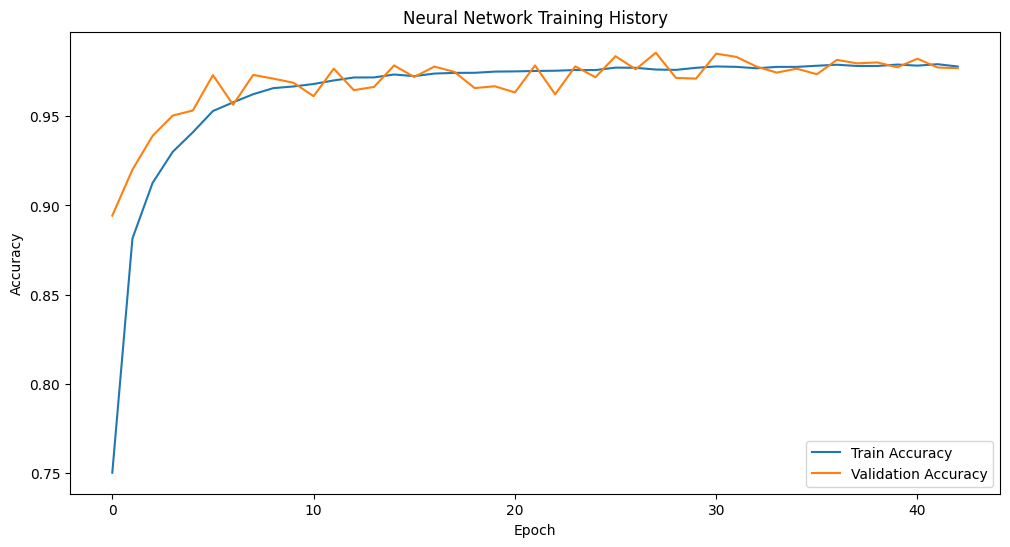

In [ ]:
# Training History Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()





In [ ]:
# Model Comparison
results = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)

    results[name] = {
        'Train Accuracy': accuracy_score(y_train, model.predict(X_train)),
        'Validation Accuracy': accuracy_score(y_val, val_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred)
    }

In [ ]:
# Neural Network Evaluation
nn_val_pred = np.argmax(nn_model.predict(X_val_scaled), axis=1)
nn_test_pred = np.argmax(nn_model.predict(X_test_scaled), axis=1)
results['Neural Network'] = {
    'Train Accuracy': accuracy_score(y_train, np.argmax(nn_model.predict(X_train_scaled), axis=1)),
    'Validation Accuracy': accuracy_score(y_val, nn_val_pred),
    'Test Accuracy': accuracy_score(y_test, nn_test_pred)
}

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


Results DataFrame

<Figure size 1400x600 with 0 Axes>

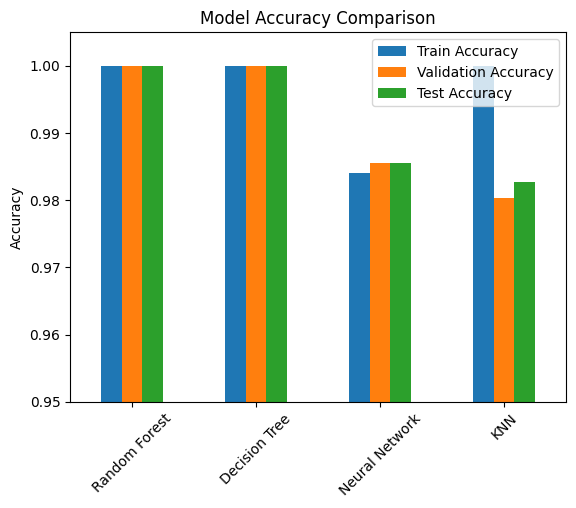

In [ ]:
# Results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Test Accuracy', ascending=False)

# Accuracy Comparison Plot
plt.figure(figsize=(14, 6))
results_df[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']].plot(kind='bar')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.95, 1.005)
plt.xticks(rotation=45)
plt.show()



# Confusion Matrix for Best Model

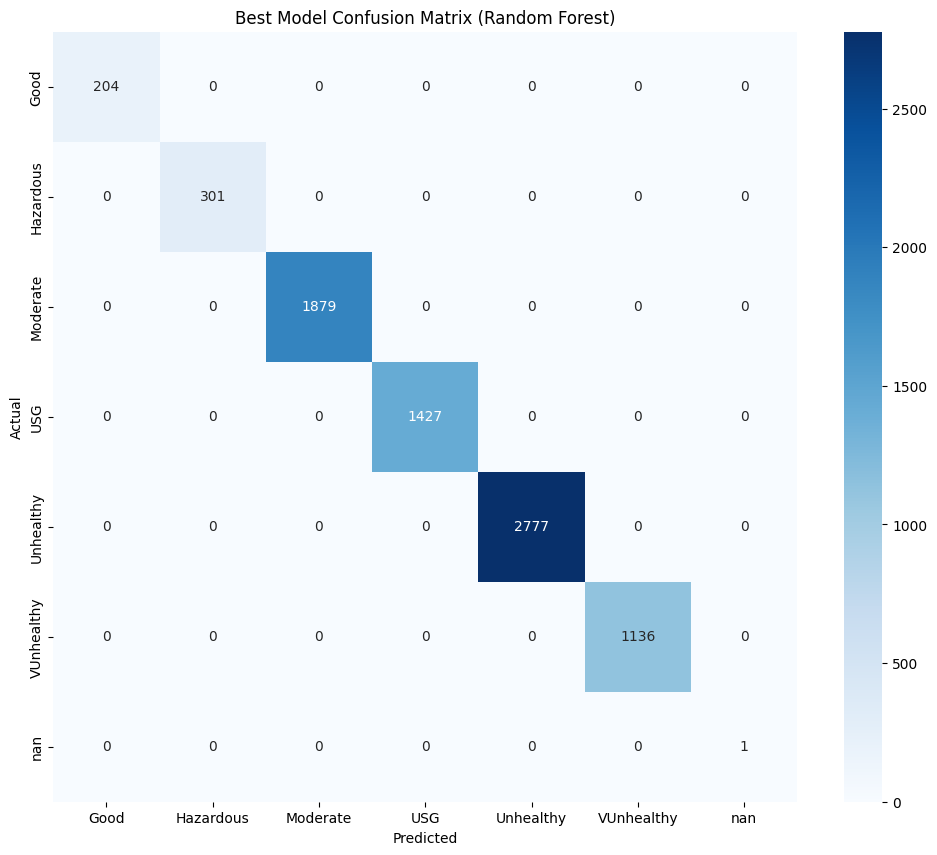

In [ ]:
# Confusion Matrix for Best Model
best_model_name = results_df.index[0]
if best_model_name == 'Neural Network':
    y_pred = nn_test_pred
else:
    y_pred = best_models[best_model_name].predict(X_test)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Best Model Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Feature Importance

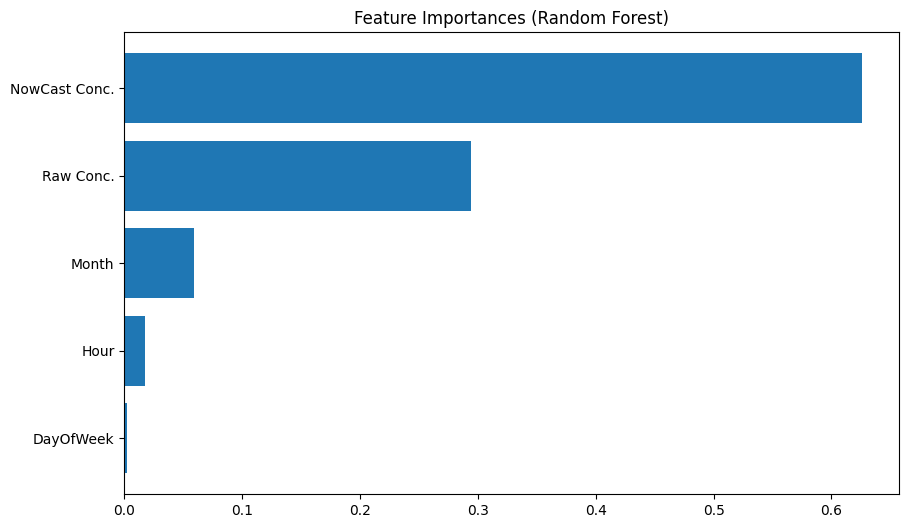

In [ ]:
# Feature Importance (For Tree-based Models)
if 'Random Forest' in best_models:
    plt.figure(figsize=(10, 6))
    importances = best_models['Random Forest'].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title("Feature Importances (Random Forest)")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.show()

# AQI Distribution Plot

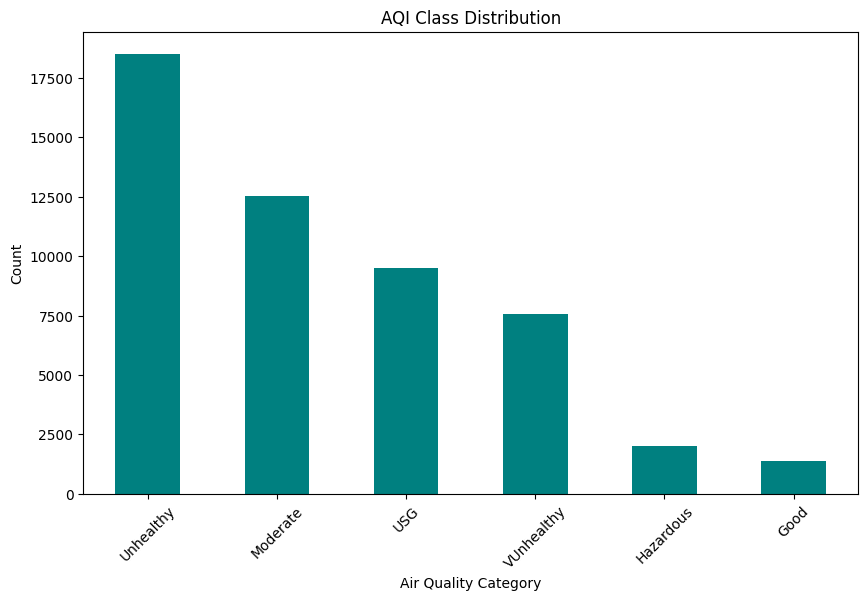

In [ ]:
# AQI Distribution Plot
plt.figure(figsize=(10, 6))
merged_df['AQI_Class'].value_counts().plot(kind='bar', color='teal')
plt.title('AQI Class Distribution')
plt.xlabel('Air Quality Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# FUTURE PREDICTION

main

In [ ]:
# AQI CALCULATION & HEALTH ADVISORY
def calculate_aqi_class(aqi_value):
    """Map AQI value to classification"""
    if aqi_value <= 50:
        return 'Good'
    elif aqi_value <= 100:
        return 'Moderate'
    elif aqi_value <= 150:
        return 'USG'
    elif aqi_value <= 200:
        return 'Unhealthy'
    elif aqi_value <= 300:
        return 'VUnhealthy'
    else:
        return 'Hazardous'

def health_status(aqi_class, aqi_value):
    """Provides detailed health advisory"""
    advisories = {
        'Good': {
            'range': '0-50',
            'message': "Air quality is satisfactory, posing little or no risk."
        },
        'Moderate': {
            'range': '51-100',
            'message': "Acceptable quality, but some pollutants may affect sensitive individuals."
        },
        'USG': {
            'range': '101-150',
            'message': "Sensitive groups should reduce outdoor exertion."
        },
        'Unhealthy': {
            'range': '151-200',
            'message': "Everyone may experience health effects."
        },
        'VUnhealthy': {
            'range': '201-300',
            'message': "Health alert - significant health risk."
        },
        'Hazardous': {
            'range': '300+',
            'message': "Health warning of emergency conditions."
        }
    }

    status = advisories.get(aqi_class, {'range': 'N/A', 'message': 'Unknown status'})
    return (
        f"AQI: {aqi_value:.0f} ({aqi_class})\n"
        f"Range: {status['range']}\n"
        f"Advisory: {status['message']}\n"
        f"Health Status: {'Healthy ✅' if aqi_class in ['Good', 'Moderate'] else 'Unhealthy ⚠️'}"
    )

# ENHANCED PREDICTION INTERFACE
def get_date_prediction():
    print("\n=== Date-Based AQI Forecast ===")
    date_str = input("Enter prediction date (DD/MM/YYYY HH:MM): ")
    dt = pd.to_datetime(date_str, format='%d/%m/%Y %H:%M')

    # Find historical pattern
    match = historical_df[
        (historical_df['Month'] == dt.month) &
        (historical_df['DayOfWeek'] == dt.dayofweek) &
        (historical_df['Hour'] == dt.hour)
    ]

    if not match.empty:
        features = match.iloc[0][['NowCast Conc.', 'Raw Conc.', 'Hour', 'Month', 'DayOfWeek']]
        aqi_value = features['NowCast Conc.'] * 2  # Conversion factor based on your data
    else:
        features = pd.Series({
            'NowCast Conc.': merged_df['NowCast Conc.'].mean(),
            'Raw Conc.': merged_df['Raw Conc.'].mean(),
            'Hour': dt.hour,
            'Month': dt.month,
            'DayOfWeek': dt.dayofweek
        })
        aqi_value = features['NowCast Conc.'].mean() * 2

    aqi_class = calculate_aqi_class(aqi_value)
    return pd.DataFrame([features]), dt, aqi_value, aqi_class

# Generate prediction
try:
    user_features, prediction_dt, aqi_value, aqi_class = get_date_prediction()

    # Display results
    print("\n=== Prediction Result ===")
    print(f"Date: {prediction_dt.strftime('%d-%b-%Y %H:%M')}")
    print(f"Historical Features:\n{user_features}\n")
    print(health_status(aqi_class, aqi_value))
    print("="*40)

except Exception as e:
    print(f"Error: {str(e)}")


=== Date-Based AQI Forecast ===
Enter prediction date (DD/MM/YYYY HH:MM): 25/05/2025 2:00

=== Prediction Result ===
Date: 25-May-2025 02:00
Historical Features:
     NowCast Conc.   Raw Conc.  Hour  Month  DayOfWeek
818      52.389286 -136.821429   2.0    5.0        6.0

AQI: 105 (USG)
Range: 101-150
Advisory: Sensitive groups should reduce outdoor exertion.
Health Status: Unhealthy ⚠️
